![banner](https://drive.google.com/uc?id=1qLz2QP1w_46OSAHCqnrhY1kvACkkwCe4)

**Desarrollado por:**

- Eduard Alfonso Caballero Ponguta - 2151099
- María Camila Aparicio Nova - 2161907
- Iván Rodrigo Castillo Cañas - 2160023


In [ ]:
#@title Importar Librerías
import pandas as pd
import random
import os
import numpy as np
import io
import IPython
from google.colab import output
from datetime import datetime
!pip install ffmpeg-python
import ffmpeg

from scipy.io import wavfile
from scipy.fftpack import fft
from scipy import signal
from scipy.io.wavfile import read as wav_read
import scipy


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix

from keras.utils import to_categorical
import tensorflow as tf


import librosa
import librosa.display

from tqdm.notebook import tqdm
from IPython.display import clear_output
from google.colab import drive
import matplotlib.pyplot as plt
from os.path import isdir, join
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode

from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

#Implementación
import time
!pip install pydub
from pydub import AudioSegment
from pydub.silence import split_on_silence

%matplotlib inline
clear_output()

In [ ]:
#@title Cargar google drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/IA2/DATA/')
clear_output()

In [ ]:
#@title Funciones
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var screen = document.createElement("DIV");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Grabar");
var t2 = document.createTextNode("00 : 00");

screen.appendChild(t2);
my_btn.appendChild(t);
my_div.appendChild(my_btn);
document.body.appendChild(screen);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var play = false;
var recorder, gumStream;
var recordButton = my_btn;
var screenInfo = screen;
var isMarch = false; 
var acumularTime = 0; 

function cronometro () { 
  timeActual = new Date();
  acumularTime = timeActual - timeInicial;
  acumularTime2 = new Date();
  acumularTime2.setTime(acumularTime); 
  cc = Math.round(acumularTime2.getMilliseconds()/10);
  ss = acumularTime2.getSeconds();
  if (cc < 10) {cc = "0"+cc;}
  if (ss < 10) {ss = "0"+ss;} 
  screenInfo.innerHTML = ss+" : "+cc;
}

function start() {
  if (isMarch == false) { 
    timeInicial = new Date();
    control = setInterval(cronometro,10);
    isMarch = true;
  }
}

function stop() { 
  if (isMarch == true) {
    clearInterval(control);
    isMarch = false;
  }     
}      


var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
    }
  };
  recorder.start();
};

function grabar() {
  recordButton.innerText = "Parar";
  navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);
  start();
}


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Guardando el audio..."
  }
}

function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
  console.log("click")
if (play){
  console.log("stop")
  toggleRecording()
}else{
  console.log("play")
  grabar()
  play = true
}

sleep(5000).then(() => {
  resolve(base64data.toString())
  recordButton.innerText = "Guardado con exito!"
});

}
});
      
</script>
"""
BULB_HTML = """
<script>
var my_div = document.createElement("DIV");
var image = document.createElement("IMG");

image.setAttribute("src", "https://media.geeksforgeeks.org/wp-content/uploads/OFFbulb.jpg");
document.body.appendChild(my_div);

var div_image = image;

function turnOnOff()  
// taking image in image variable 
var image = document.getElementById('Image'); 

//Match the image name 
//whether it is ONbulb or OFFbulb 
//change image to OFFbulb.jpg if 
//it match with ONbulb otherwise 
//change it to ONbulb.jpg --> 
if (image.src.match("ONbulb")) 
    div_image.src = "https://media.geeksforgeeks.org/ 
                wp-content/uploads/OFFbulb.jpg"; 
else
    div_image.src = "https://media.geeksforgeeks.org/ 
                wp-content/uploads/ONbulb.jpg"; 
}
</script>
"""

def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

def extract_features(train_audio_path, file_name):
  audio, sample_rate = librosa.load(train_audio_path+file_name, res_type='kaiser_fast') 
  mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=80)
  mfccs_processed = np.mean(mfccs.T,axis=0)
  return mfccs_processed

def extract_features_chroma(train_audio_path, file_name):
  audio, sample_rate = librosa.load(train_audio_path+file_name, res_type='kaiser_fast') 
  stft = np.abs(librosa.stft(audio))
  chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
  return chroma

def remove_label_from_file(label, fname):
    return fname[len(label)+1:]

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))
  now = datetime.now()
  name = now.strftime('%d_%m_%Y_%H_%M_%S')
  scipy.io.wavfile.write('/content/drive/My Drive/IA2/DATA/Recs/rec_'+name+'.wav', sr, audio)

  return audio, sr, 'rec_'+name+'.wav'

##1. OBJETIVOS DEL PROYECTO

La accesibilidad de los dispositivos inteligentes en la actualidad es un factor incidente en la autonomía de tareas y flujo de actividades cotidianas. Existen asistentes por voz que se basan en tecnología con Inteligencia Artificial donde las redes neuronales han mostrado ser una herramienta versátil capaz de modelar todos los aspectos acústicos, fonéticos y lingüísticos asociados con la tarea de reconocimiento de voz.


### **Objetivo general**

- Reconocer comandos de voz simples en inglés mediante una interfaz que registra la voz y ejecuta acciones de acuerdo los comandos detectados en audios grabados, facilitando la interacción y accesibilidad con dispositivos inteligentes.

### **Objetivos especificos**

-  Construir modelos DNN, RNN, LSTM y GRU que permitan el reconocimiento de diferentes tipos de comandos de voz.
- Evalúar los modelos entrenados mediante dos tipos de pruebas: por pablabras y por frases.
-  Determinar el modelo que ofrezca mejores resultados en rendimiento y accuracy.

### Preguntas por responder



- **Problema a resolver:**  
R: ¿Es posible reconocer comandos de voz simples que permitan ejecutar acciones en dispositivos con acceso a micrófono?
- **¿Como se va resolver?**  
R: Por medio de varios tratamientos que permitan una mejor representacion de la información y la construccion de modelos Deep Learning para reconocer los comandos hablados.
- **¿Por qué se necesita resolver este problema?**  
R: Porque el internet de las cosas (IoT) cada vez está más presente en los dispositivos y electrodomésticos que se usan diariamente, los cuales se reinventan para ser cada vez más compactos como, por ejemplo, poder *mandar* a un dispositivo mediante comando de voz para que ejecute tareas, sin la necesidad de entrar en contacto directo con una pantalla como es el caso de Alexa, Siri o AG.
- **¿Para que?**  
R: Reducir el uso de pantallas y facilitar el uso de dispositivos en personas con alguna discapacidad motriz.
- **¿Para quien(es) seria util esta solucion?**  
R: Para empresas desarrolladoras de dispositivos electronicos o servicios web, que requieran el uso de reconocimiento de voz.

# 2. TRATAMIENTO DE AUDIOS
El dataset que se utilizó para este proyecto se obtuvo de [kaggle](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge ), el cual consta de las siguientes características:

* 65.000 audios de comandos grabados en inglés por diferentes tonos de voz.
* 30 clases (comandos).
* Cada audio dura un segundo.
* formato .wav






### Selección de comandos
Se seleccionan las grabaciones correspondientes de los comandos correspondientes a **yes, no, on, off, stop.**

Además, se crea una clase llamada **unknown** a partir de la concatenación de los comandos one, five y dog. 


| Comandos | Descripción |
|-----------------------|---------------------------------------------------------------------------------|
| **yes** | 2377 audios de 1 segundo pronunciados por diferentes personas (formato: wav) |
| **no** | 2375 audios de 1 segundo pronunciados por diferentes personas (formato: wav) |
| **on** | 2365 audios de 1 segundo pronunciados por diferentes personas (formato: wav) |
|  **off** | 2357 audios de 1 segundo pronunciados por diferentes personas (formato: wav) |
|  **stop** | 2357 audios de 1 segundo pronunciados por diferentes personas (formato: wav) |
|  **unknown** | 7021 audios de 1 segundo pronunciados por diferentes personas (formato: wav) |

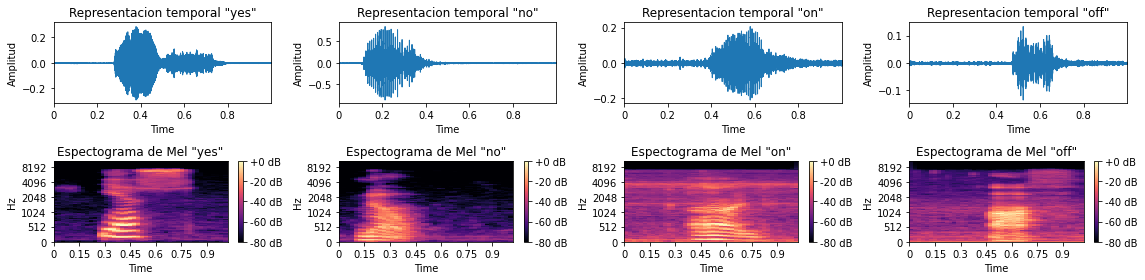

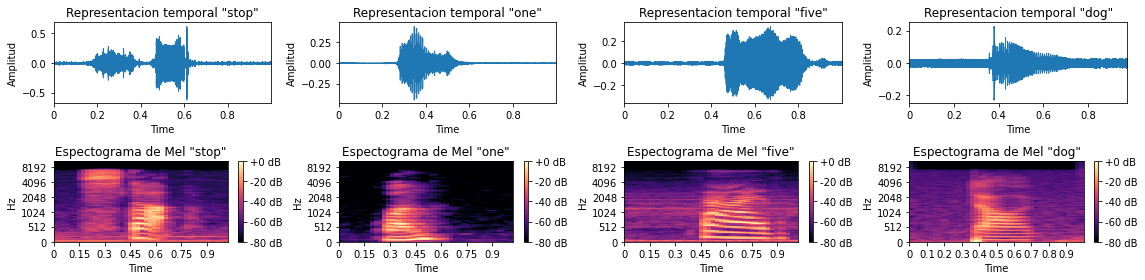

In [ ]:
#@title Representación gráfica
#@markdown Se grafica la representacion temporal y el espectograma de mel para una muestra  de cada clase
train_audio_path = 'train/audio/'
yes = '/yes/0a7c2a8d_nohash_0.wav'
no = '/no/b4aa9fef_nohash_0.wav'
on = '/on/5af0ca83_nohash_1.wav'
off = '/off/924c1a04_nohash_1.wav'
stop = '/stop/0fa1e7a9_nohash_0.wav'
one = '/one/ffd2ba2f_nohash_2.wav'
five = '/five/ff21fb59_nohash_1.wav'
dog=  '/dog/fde2dee7_nohash_1.wav'

samples_yes, sample_rate_yes = librosa.load(str(train_audio_path)+yes)
S_yes = librosa.feature.melspectrogram(samples_yes, sr=sample_rate_yes, n_mels=128)
log_S_yes = librosa.power_to_db(S_yes, ref=np.max)

samples_no, sample_rate_no = librosa.load(str(train_audio_path)+no)
S_no = librosa.feature.melspectrogram(samples_no, sr=sample_rate_no, n_mels=128)
log_S_no = librosa.power_to_db(S_no, ref=np.max)

samples_on, sample_rate_on = librosa.load(str(train_audio_path)+on)
S_on = librosa.feature.melspectrogram(samples_on, sr=sample_rate_on, n_mels=128)
log_S_on = librosa.power_to_db(S_on, ref=np.max)

samples_off, sample_rate_off = librosa.load(str(train_audio_path)+off)
S_off = librosa.feature.melspectrogram(samples_off, sr=sample_rate_off, n_mels=128)
log_S_off = librosa.power_to_db(S_off, ref=np.max)

samples_stop, sample_rate_stop = librosa.load(str(train_audio_path)+stop)
S_stop = librosa.feature.melspectrogram(samples_stop, sr=sample_rate_stop, n_mels=128)
log_S_stop = librosa.power_to_db(S_stop, ref=np.max)

samples_one, sample_rate_one = librosa.load(str(train_audio_path)+one)
S_one = librosa.feature.melspectrogram(samples_one, sr=sample_rate_one, n_mels=128)
log_S_one = librosa.power_to_db(S_one, ref=np.max)

samples_five, sample_rate_five = librosa.load(str(train_audio_path)+five)
S_five = librosa.feature.melspectrogram(samples_five, sr=sample_rate_five, n_mels=128)
log_S_five = librosa.power_to_db(S_five, ref=np.max)

samples_dog, sample_rate_dog = librosa.load(str(train_audio_path)+dog)
S_dog = librosa.feature.melspectrogram(samples_dog, sr=sample_rate_dog, n_mels=128)
log_S_dog = librosa.power_to_db(S_dog, ref=np.max)

#fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(nrows=2, ncols=5)
fig1 = plt.figure(figsize=(16, 4))

plt.subplot(2,4,1)
librosa.display.waveplot(samples_yes, sr=sample_rate_yes)
plt.title('Representacion temporal "yes"')
plt.ylabel('Amplitud')

plt.subplot(2,4,5)
librosa.display.specshow(log_S_yes, sr=sample_rate_yes, x_axis='time', y_axis='mel')
plt.title('Espectograma de Mel "yes"')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

plt.subplot(2,4,2)
librosa.display.waveplot(samples_no, sr=sample_rate_no)
plt.title('Representacion temporal "no"')
plt.ylabel('Amplitud')

plt.subplot(2,4,6)
librosa.display.specshow(log_S_no, sr=sample_rate_no, x_axis='time', y_axis='mel')
plt.title('Espectograma de Mel "no"')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

plt.subplot(2,4,3)
librosa.display.waveplot(samples_on, sr=sample_rate_on)
plt.title('Representacion temporal "on"')
plt.ylabel('Amplitud')

plt.subplot(2,4,7)
librosa.display.specshow(log_S_on, sr=sample_rate_on, x_axis='time', y_axis='mel')
plt.title('Espectograma de Mel "on"')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()


plt.subplot(2,4,4)
librosa.display.waveplot(samples_off, sr=sample_rate_off)
plt.title('Representacion temporal "off"')
plt.ylabel('Amplitud')

plt.subplot(2,4,8)
librosa.display.specshow(log_S_off, sr=sample_rate_off, x_axis='time', y_axis='mel')
plt.title('Espectograma de Mel "off"')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

fig2 = plt.figure(figsize=(16, 4))

plt.subplot(2,4,1)
librosa.display.waveplot(samples_stop, sr=sample_rate_stop)
plt.title('Representacion temporal "stop"')
plt.ylabel('Amplitud')

plt.subplot(2,4,5)
librosa.display.specshow(log_S_stop, sr=sample_rate_stop, x_axis='time', y_axis='mel')
plt.title('Espectograma de Mel "stop"')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

plt.subplot(2,4,2)
librosa.display.waveplot(samples_one, sr=sample_rate_one)
plt.title('Representacion temporal "one"')
plt.ylabel('Amplitud')

plt.subplot(2,4,6)
librosa.display.specshow(log_S_one, sr=sample_rate_one, x_axis='time', y_axis='mel')
plt.title('Espectograma de Mel "one"')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

plt.subplot(2,4,3)
librosa.display.waveplot(samples_five, sr=sample_rate_five)
plt.title('Representacion temporal "five"')
plt.ylabel('Amplitud')

plt.subplot(2,4,7)
librosa.display.specshow(log_S_five, sr=sample_rate_five, x_axis='time', y_axis='mel')
plt.title('Espectograma de Mel "five"')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

plt.subplot(2,4,4)
librosa.display.waveplot(samples_dog, sr=sample_rate_dog)
plt.title('Representacion temporal "dog"')
plt.ylabel('Amplitud')

plt.subplot(2,4,8)
librosa.display.specshow(log_S_dog, sr=sample_rate_dog, x_axis='time', y_axis='mel')
plt.title('Espectograma de Mel "dog"')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()
plt.show()
# Audio(samples, rate=sample_rate)

### Dataset de entrenamiento
Se extraen las características MFCC y Chroma con librosa para crear un dataset de entrenamiento. Además, se particiona este dataset en una cantidad de audios para entrenamiento y testeo respectivamente.

![alt text](https://drive.google.com/uc?id=1-99kFGwxhn7wR5DZRMuQ6kLFix48k0KS)

In [ ]:
#@title Partición del dataset
size = 650 #@param {type:"slider", min:50, max:2300, step:100}
shuffle = "True" #@param ['True','False']
# train_labels = os.listdir(train_audio_path)
# train_labels.remove('_background_noise_')


labels_to_keep = ['yes', 'no', 'on', 'off','stop', 'one','five','dog']
# labels_to_keep = ['up', 'down', 'left', 'right']

#num_labels = len(labels_to_keep)
train_audio_path = 'train/audio/'

# train_file_labels = dict()
features = []
unknow = []

for label in labels_to_keep[:5]:
  files = os.listdir(train_audio_path + '/' + label)
  if (shuffle == "True"): 
    random.shuffle(files)
  for f in tqdm(files[:size]):
    file_name = label + '/' + f
    mfcc  = extract_features(train_audio_path, str(file_name))
    chroma  = extract_features_chroma(train_audio_path, str(file_name))
    features.append([f, np.concatenate((mfcc, chroma)), label])

#Ruido Class Unknow
for label in labels_to_keep[5:]:
  files = os.listdir(train_audio_path + '/' + label)
  if (shuffle == "True"): 
    random.shuffle(files)
  for f in tqdm(files[:size]):
    file_name = label + '/' + f
    mfcc  = extract_features(train_audio_path, str(file_name))
    chroma  = extract_features_chroma(train_audio_path, str(file_name))
    unknow.append([f, np.concatenate((mfcc, chroma)), 'unknow'])
random.shuffle(unknow)
features += unknow
data_audio = pd.DataFrame(features, columns=['file','features','class_label'])
data_audio.sample(5)

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


,file,features,class_label
3800,d1214f15_nohash_1.wav,"[-567.0991045495317, 73.8521946474203, -28.526...",unknow
347,d90b4138_nohash_3.wav,"[-644.4743070646825, 52.65493282993103, -1.445...",yes
686,573cdb8a_nohash_1.wav,"[-679.8258806071126, 79.77227173624026, -19.74...",no
4277,5b1db3ee_nohash_0.wav,"[-548.0019147073128, 95.93727402425051, -18.87...",unknow
2200,d0faf7e4_nohash_4.wav,"[-395.0501611888109, 126.29257403457987, 19.88...",off


In [ ]:
#@title Partición de test y codificación
test_size = 0.25 #@param {type:"slider", min:0.1, max:1, step:0.05}

# Convertimos las features y labels a numpy arrays
num_labels = 6
X = np.array(data_audio.features.tolist())
y = np.array(data_audio.class_label.tolist())

# Codificamos los labels con Encoder
le = LabelEncoder()
y_encode = to_categorical(le.fit_transform(y))

# Split
x_train, x_test, y_train, y_test = train_test_split(X, y_encode, test_size=test_size)

In [ ]:
print(f"Dataset shape: Train:{x_train.shape}, Test:{y_test.shape}")

Dataset shape: Train:(3900, 92), Test:(1300, 6)


#3. DEFINICIÓN DE MODELOS
Se definen y entrenan modelos DNN y RNN con las características extraídas en el enunciado anterior.

##Entrenamiento Modelo RNN

In [ ]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential( )
simpleRNN1 = tf.keras.layers.Bidirectional((tf.keras.layers.SimpleRNN(units=512,
                                       return_sequences=True,
                                       activation='tanh',
                                       name='RNN_layer1')))

simpleRNN2 = tf.keras.layers.Bidirectional((tf.keras.layers.SimpleRNN(units=512,
                                       return_sequences=True,
                                       activation='tanh',
                                       name='RNN_layer2')))

simpleRNN3 = tf.keras.layers.Bidirectional((tf.keras.layers.SimpleRNN(units=512,
                                       return_sequences=False,
                                       activation='tanh',
                                       name='RNN_layer3')))
# To calculate the output value                                           
dense1 = tf.keras.layers.Dense(units=256, 
                                   activation='relu',
                                   name='dense1')
dense2 = tf.keras.layers.Dense(units=128, 
                                   activation='relu',
                                   name='dense2')
dense3 = tf.keras.layers.Dense(units = num_labels,
                                  activation='softmax',
                                  name='ouput_layer')
############################################################################
# Create the model
input_ = tf.keras.layers.Input((92,1))
x = simpleRNN1(input_)
x = simpleRNN2(x)
x = simpleRNN3(x)
x = dense1(x)
x = dense2(x)
y = dense3(x)
############################################################################

model = tf.keras.Model(inputs=input_, outputs=y, name="Modelo_RNN")
model.summary()

Model: "Modelo_RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 92, 1)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 92, 1024)          526336    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 92, 1024)          1573888   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1024)              1573888   
_________________________________________________________________
dense1 (Dense)               (None, 256)               262400    
_________________________________________________________________
dense2 (Dense)               (None, 128)               32896     
_________________________________________________________________
ouput_layer (Dense)          (None, 6)                 7

In [ ]:
X = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
X.shape
y_train.shape

(2925, 6)

### 50 Epochs

Epoch 1/50
122/122 [==============================] - 32s 260ms/step - loss: 1.7214 - accuracy: 0.3436
Epoch 2/50
122/122 [==============================] - 32s 259ms/step - loss: 1.5776 - accuracy: 0.3938
Epoch 3/50
122/122 [==============================] - 31s 257ms/step - loss: 1.4186 - accuracy: 0.4495
Epoch 4/50
122/122 [==============================] - 32s 259ms/step - loss: 1.3911 - accuracy: 0.4633
Epoch 5/50
122/122 [==============================] - 32s 260ms/step - loss: 1.3520 - accuracy: 0.4728
Epoch 6/50
122/122 [==============================] - 32s 261ms/step - loss: 1.3419 - accuracy: 0.4733
Epoch 7/50
122/122 [==============================] - 32s 260ms/step - loss: 1.3554 - accuracy: 0.4654
Epoch 8/50
122/122 [==============================] - 32s 261ms/step - loss: 1.3174 - accuracy: 0.4900
Epoch 9/50
122/122 [==============================] - 32s 262ms/step - loss: 1.3095 - accuracy: 0.4921
Epoch 10/50
122/122 [==============================] - 32s 263ms/step - l

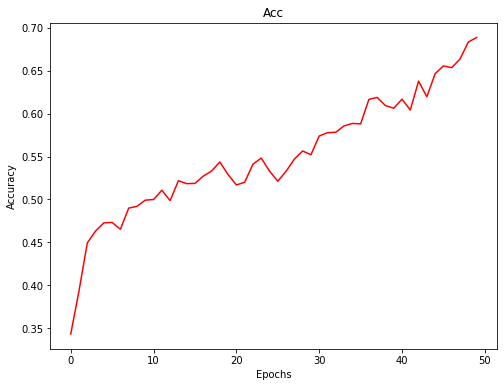

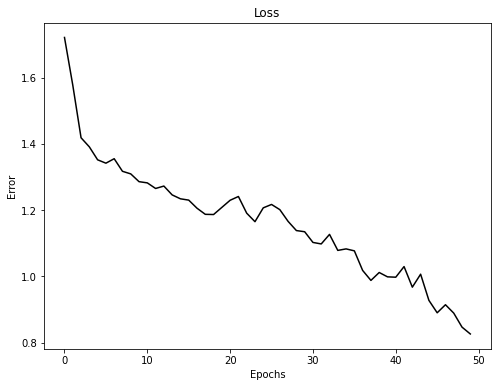

In [ ]:
#@title Entrenamiento
epochs = 50 #@param {type:"slider", min:50, max:5000, step:50}

optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
# optimizer = tf.keras.optimizers.Adam(lr=1e-4)
# optimizer = tf.keras.optimizers.Adadelta(lr=1e-4)

# optimizer = 'adam' #@param ["adam", "SGD", "adadelta"]

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=optimizer)
X = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
# print(X.shape, y_train.shape)
history = model.fit(X, y_train,epochs=epochs,verbose=1)

acc = history.history['accuracy']
loss = history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot acc and Loss
#------------------------------------------------
plt.figure(figsize=(8, 6));
plt.plot(epochs, acc, 'red', label='acc')
plt.title('Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show();
plt.figure(figsize=(8, 6));
plt.title('Loss')
plt.plot(epochs, loss, 'black', label='loss')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show();

In [ ]:
#@markdown optimizer_epochs_samples_features_accuracy_version

nombre = "RNN_SGD_50e_650m_2f_0.76_V1" #@param {type:"string"}
model.save('/content/drive/My Drive/IA2/DATA/Models/model_'+nombre+'.h5')
np.save('/content/drive/My Drive/IA2/DATA/Models/model_'+nombre+'.npy', le.classes_)

In [ ]:
# Cargar modelo
model = tf.keras.models.load_model('/content/drive/My Drive/IA2/DATA/Models/model_RNN_SGD_50e_650m_2f_0.76_V1.h5')

In [ ]:
#@title Predecición
X_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)
y_predict = np.argmax(model.predict(X_test), axis=1)
y_test_single = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_test_single, y_predict)
print(conf_matrix)

[[ 85   4  13  14  18   7]
 [ 14 104  25  26  13   6]
 [ 25  27  69  18  26   3]
 [ 10  19   9  95  18  11]
 [124  42  72  85 134  31]
 [  9   3   3  15  10 113]]


In [ ]:
text = ["ON", "OFF", "YES", "NO", "STOP", "UNKNOWN"]
#Vector para gráficas
RNN50=[]
for i in range(len(text)):
  acierto_promedio = conf_matrix[i][i]/(np.sum(conf_matrix[i], axis=0))
  RNN50.append(np.round(acierto_promedio, 2))
  print(f"Aciertos clase {text[i]}: {np.round(acierto_promedio*100, 2)}%")

Aciertos clase ON: 60.28%
Aciertos clase OFF: 55.32%
Aciertos clase YES: 41.07%
Aciertos clase NO: 58.64%
Aciertos clase STOP: 27.46%
Aciertos clase UNKNOWN: 73.86%


### 100 Epochs 

Epoch 1/100
122/122 [==============================] - 33s 267ms/step - loss: 1.2876 - accuracy: 0.5085
Epoch 2/100
122/122 [==============================] - 33s 267ms/step - loss: 1.1208 - accuracy: 0.5710
Epoch 3/100
122/122 [==============================] - 32s 266ms/step - loss: 1.0425 - accuracy: 0.5928
Epoch 4/100
122/122 [==============================] - 32s 265ms/step - loss: 1.0609 - accuracy: 0.5926
Epoch 5/100
122/122 [==============================] - 32s 265ms/step - loss: 1.1061 - accuracy: 0.5695
Epoch 6/100
122/122 [==============================] - 33s 271ms/step - loss: 1.1501 - accuracy: 0.5503
Epoch 7/100
122/122 [==============================] - 32s 265ms/step - loss: 1.0840 - accuracy: 0.5697
Epoch 8/100
122/122 [==============================] - 33s 267ms/step - loss: 1.0597 - accuracy: 0.5885
Epoch 9/100
122/122 [==============================] - 32s 266ms/step - loss: 1.0284 - accuracy: 0.5964
Epoch 10/100
122/122 [==============================] - 32s 265m

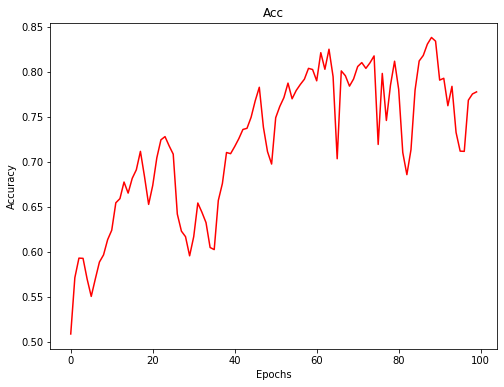

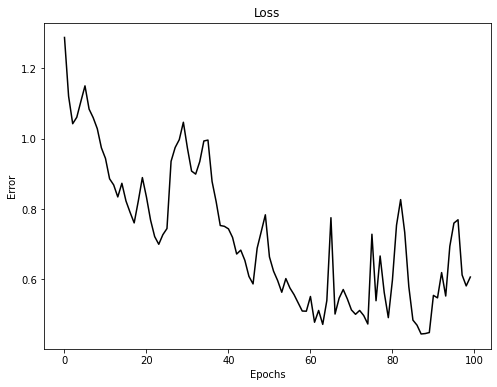

In [ ]:
#@title Entrenamiento
epochs = 100 #@param {type:"slider", min:50, max:5000, step:50}

optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
# optimizer = tf.keras.optimizers.Adam(lr=1e-4)
# optimizer = tf.keras.optimizers.Adadelta(lr=1e-4)

# optimizer = 'adam' #@param ["adam", "SGD", "adadelta"]

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=optimizer)
X = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
# print(X.shape, y_train.shape)
history = model.fit(X, y_train,epochs=epochs,verbose=1)

acc = history.history['accuracy']
loss = history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot acc and Loss
#------------------------------------------------
plt.figure(figsize=(8, 6));
plt.plot(epochs, acc, 'red', label='acc')
plt.title('Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show();
plt.figure(figsize=(8, 6));
plt.title('Loss')
plt.plot(epochs, loss, 'black', label='loss')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show();

In [ ]:
#Guardar modelo
#@markdown optimizer_epochs_samples_features_accuracy_version

nombre = "RNN_SGD_100e_650m_2f_0.77_V1" #@param {type:"string"}
model.save('/content/drive/My Drive/IA2/DATA/Models/model_'+nombre+'.h5')
np.save('/content/drive/My Drive/IA2/DATA/Models/model_'+nombre+'.npy', le.classes_)

In [ ]:
# Cargar modelo
model = tf.keras.models.load_model('Models/model_RNN_SGD_100e_650m_2f_0.77_V1.h5')

In [ ]:
#@title Predicción
X_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)
y_predict = np.argmax(model.predict(X_test), axis=1)
y_test_single = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_test_single, y_predict)
print(conf_matrix)

[[ 35   5   9   7  81   4]
 [  8  76  25  25  51   3]
 [ 10  28  45  10  72   3]
 [  2  18  10  57  63  12]
 [ 58  28  50  26 302  24]
 [  8   4   1   8  32 100]]


In [ ]:
text = ["ON", "OFF", "YES", "NO", "STOP", "UNKNOWN"]
#Vector para gráficas
RNN100=[]
for i in range(len(text)):
  acierto_promedio = conf_matrix[i][i]/(np.sum(conf_matrix[i], axis=0))
  RNN100.append(np.round(acierto_promedio, 2))
  print(f"Aciertos clase {text[i]}: {np.round(acierto_promedio*100, 2)}%")

Aciertos clase ON: 24.82%
Aciertos clase OFF: 40.43%
Aciertos clase YES: 26.79%
Aciertos clase NO: 35.19%
Aciertos clase STOP: 61.89%
Aciertos clase UNKNOWN: 65.36%


### Resultados con RNN
Se visualizan los resultados de la predicción de audios (test split) en los modelos entrenados con 50 y 100 Epochs.

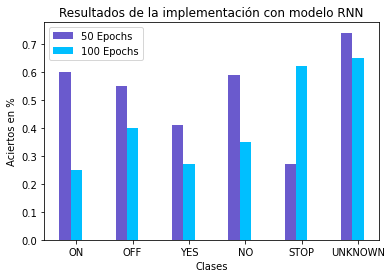

In [ ]:
# # RNN50=[68.67,52.86,58.33,69.43,82.31]
# # RNN100 = [67.63,51.14,61.54,67.52,74.15]

# txt=["ON", "OFF", "YES", "NO", "STOP", "UNKNOWN"]

barWidth=0.2
plt.bar(np.arange(len(RNN50)), RNN50, color="#6A5ACD", width=barWidth, label="50 Epochs");
plt.bar([x + barWidth for x in np.arange(len(RNN50))], RNN100, color="#00BFFF", width=barWidth, label="100 Epochs");
plt.xlabel("Clases");
plt.ylabel("Aciertos en %");
plt.xticks([r + barWidth for r in range(len(text))], txt);
plt.title("Resultados de la implementación con modelo RNN");
plt.legend();
plt.show();

##Entrenamiento Modelo LSTM

In [ ]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential(name="Modelo_LSTM")
# model.add(tf.keras.layers.Embedding(4, 300, input_length=40))
model.add(tf.keras.layers.Input((92,1)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=512,
                                                          return_sequences=True,
                                                          activation='tanh',
                                                          name='bilstm_layer1')))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=512,
                                                          return_sequences=True,
                                                          activation='tanh',
                                                          name='bilstm_layer2')))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=256,
                                                          return_sequences=False,
                                                          activation='tanh',
                                                          name='bilstm_layer3')))
model.add(tf.keras.layers.Dense(units=512, 
                                   activation='relu',
                                   name='dense1') )
model.add(tf.keras.layers.Dense(units=256, 
                                   activation='relu',
                                   name='dense2') )
model.add(tf.keras.layers.Dense(units = num_labels,
                                  activation='softmax',
                                  name='ouput_layer'))

model.summary()

Model: "Modelo_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 92, 1024)          2105344   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 92, 1024)          6295552   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               2623488   
_________________________________________________________________
dense1 (Dense)               (None, 512)               262656    
_________________________________________________________________
dense2 (Dense)               (None, 256)               131328    
_________________________________________________________________
ouput_layer (Dense)          (None, 6)                 1542      
Total params: 11,419,910
Trainable params: 11,419,910
Non-trainable params: 0
___________________________________________

### 50 Epochs

Epoch 1/50
122/122 [==============================] - 11s 93ms/step - loss: 1.6468 - accuracy: 0.3713
Epoch 2/50
122/122 [==============================] - 11s 93ms/step - loss: 1.5851 - accuracy: 0.3841
Epoch 3/50
122/122 [==============================] - 11s 93ms/step - loss: 1.5280 - accuracy: 0.4105
Epoch 4/50
122/122 [==============================] - 11s 93ms/step - loss: 1.4904 - accuracy: 0.4241
Epoch 5/50
122/122 [==============================] - 11s 93ms/step - loss: 1.4550 - accuracy: 0.4390
Epoch 6/50
122/122 [==============================] - 11s 93ms/step - loss: 1.4315 - accuracy: 0.4436
Epoch 7/50
122/122 [==============================] - 11s 94ms/step - loss: 1.4204 - accuracy: 0.4572
Epoch 8/50
122/122 [==============================] - 11s 93ms/step - loss: 1.3956 - accuracy: 0.4590
Epoch 9/50
122/122 [==============================] - 11s 93ms/step - loss: 1.3943 - accuracy: 0.4574
Epoch 10/50
122/122 [==============================] - 11s 93ms/step - loss: 1.370

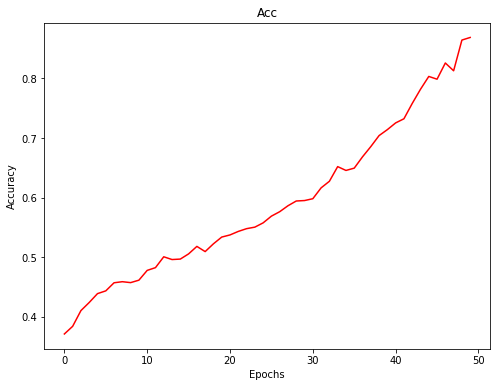

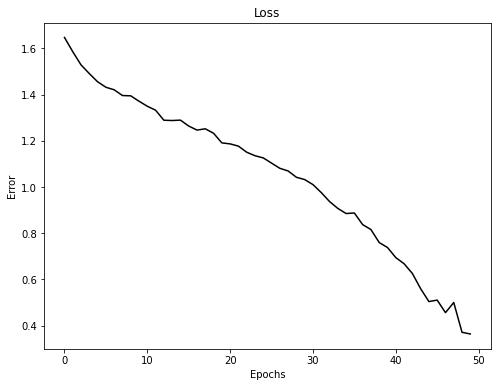

In [ ]:
#@title Entrenamiento
epochs = 50 #@param {type:"slider", min:50, max:2000, step:50}

optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
# optimizer = tf.keras.optimizers.Adam(lr=1e-4)
# optimizer = tf.keras.optimizers.Adadelta(lr=1e-4)

# optimizer = 'adam' #@param ["adam", "SGD", "adadelta"]

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=optimizer)
X = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
# print(X.shape, y_train.shape)
history = model.fit(X, y_train,epochs=epochs,verbose=1)

acc = history.history['accuracy']
loss = history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot acc and Loss
#------------------------------------------------
plt.figure(figsize=(8, 6));
plt.plot(epochs, acc, 'red', label='acc')
plt.title('Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show();
plt.figure(figsize=(8, 6));
plt.title('Loss')
plt.plot(epochs, loss, 'black', label='loss')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show();

In [ ]:
#Guardar el modelo
#@markdown optimizer_epochs_samples_features_accuracy_version

nombre = "LSTM_SGD_50e_650m_2f_0.86_V1" #@param {type:"string"}
model.save('/content/drive/My Drive/IA2/DATA/Models/model_'+nombre+'.h5')
np.save('/content/drive/My Drive/IA2/DATA/Models/model_'+nombre+'.npy', le.classes_)

In [ ]:
# Cargar modelo
model = tf.keras.models.load_model('/content/drive/My Drive/IA2/DATA/Models/model_LSTM_SGD_50e_650m_2f_0.86_V1.h5')

In [ ]:
#@title Predicción
X_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)
y_predict = model.predict_classes(X_test)
y_test_single = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_test_single, y_predict)
print(conf_matrix)

[[ 36   2   3   4  94   2]
 [  8  94  14  37  34   1]
 [ 16  17  31  19  83   2]
 [  8  33   3  69  41   8]
 [ 86  28  31  26 306  11]
 [ 17   4   3  13  28  88]]


In [ ]:
text = ["ON", "OFF", "YES", "NO", "STOP", "UNKNOWN"]
#Vector para gráficas
LSTM50=[]
for i in range(len(text)):
  acierto_promedio = conf_matrix[i][i]/(np.sum(conf_matrix[i], axis=0))
  LSTM50.append(np.round(acierto_promedio, 2))
  print(f"Aciertos clase {text[i]}: {np.round(acierto_promedio*100, 2)}%")

Aciertos clase ON: 25.53%
Aciertos clase OFF: 50.0%
Aciertos clase YES: 18.45%
Aciertos clase NO: 42.59%
Aciertos clase STOP: 62.7%
Aciertos clase UNKNOWN: 57.52%


### 100 Epochs

Epoch 1/100
122/122 [==============================] - 11s 93ms/step - loss: 1.6584 - accuracy: 0.3710
Epoch 2/100
122/122 [==============================] - 11s 93ms/step - loss: 1.5856 - accuracy: 0.3849
Epoch 3/100
122/122 [==============================] - 11s 93ms/step - loss: 1.5104 - accuracy: 0.4136
Epoch 4/100
122/122 [==============================] - 11s 93ms/step - loss: 1.4707 - accuracy: 0.4354
Epoch 5/100
122/122 [==============================] - 11s 93ms/step - loss: 1.4374 - accuracy: 0.4431
Epoch 6/100
122/122 [==============================] - 11s 93ms/step - loss: 1.4327 - accuracy: 0.4464
Epoch 7/100
122/122 [==============================] - 11s 94ms/step - loss: 1.4138 - accuracy: 0.4482
Epoch 8/100
122/122 [==============================] - 11s 94ms/step - loss: 1.3980 - accuracy: 0.4551
Epoch 9/100
122/122 [==============================] - 12s 94ms/step - loss: 1.3638 - accuracy: 0.4695
Epoch 10/100
122/122 [==============================] - 11s 94ms/step - l

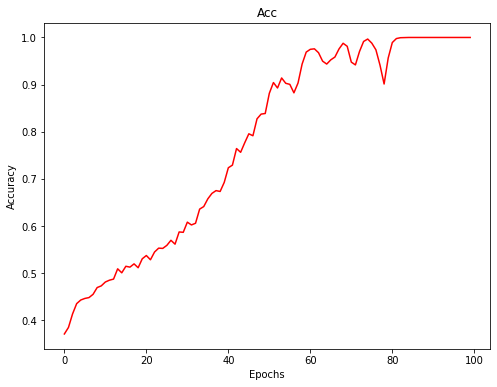

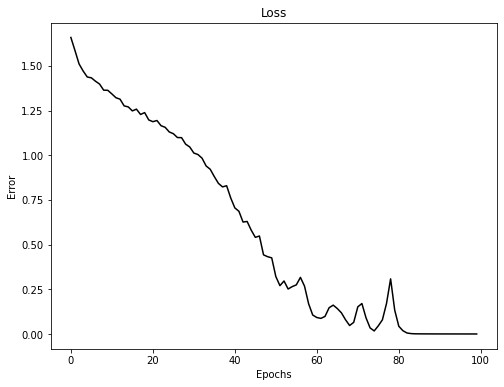

In [ ]:
#@title Entrenamiento
tf.keras.backend.clear_session()
epochs = 100 #@param {type:"slider", min:50, max:2000, step:50}

optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
# optimizer = tf.keras.optimizers.Adam(lr=1e-4)
# optimizer = tf.keras.optimizers.Adadelta(lr=1e-4)

# optimizer = 'adam' #@param ["adam", "SGD", "adadelta"]

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=optimizer)
X = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
# print(X.shape, y_train.shape)
history = model.fit(X, y_train,epochs=epochs,verbose=1)

acc = history.history['accuracy']
loss = history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot acc and Loss
#------------------------------------------------
plt.figure(figsize=(8, 6));
plt.plot(epochs, acc, 'red', label='acc')
plt.title('Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show();
plt.figure(figsize=(8, 6));
plt.title('Loss')
plt.plot(epochs, loss, 'black', label='loss')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show();

In [ ]:
#Guardar el modelo
#@markdown optimizer_epochs_samples_features_accuracy_version

nombre = "LSTM_SGD_100e_650m_2f_1_V1" #@param {type:"string"}
model.save('/content/drive/My Drive/IA2/DATA/Models/model_'+nombre+'.h5')
np.save('/content/drive/My Drive/IA2/DATA/Models/model_'+nombre+'.npy', le.classes_)

In [ ]:
# Cargar modelo
model = tf.keras.models.load_model('Models/model_LSTM_SGD_100e_650m_2f_1_V1.h5')

In [ ]:
#@title Predicción
X_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)
y_predict = model.predict_classes(X_test)
y_test_single = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_test_single, y_predict)
print(conf_matrix)

[[ 35   4  12   5  79   6]
 [  4  77  27  41  36   3]
 [  6  24  48  16  68   6]
 [  4  27  14  70  34  13]
 [ 81  22  51  23 286  25]
 [  8   2   3  13  27 100]]


In [ ]:
text = ["ON", "OFF", "YES", "NO", "STOP", "UNKNOWN"]
#Vector para gráficas
LSTM100=[]
for i in range(len(text)):
  acierto_promedio = conf_matrix[i][i]/(np.sum(conf_matrix[i], axis=0))
  LSTM100.append(np.round(acierto_promedio, 2))
  print(f"Aciertos clase {text[i]}: {np.round(acierto_promedio*100, 2)}%")

Aciertos clase ON: 24.82%
Aciertos clase OFF: 40.96%
Aciertos clase YES: 28.57%
Aciertos clase NO: 43.21%
Aciertos clase STOP: 58.61%
Aciertos clase UNKNOWN: 65.36%


### Resultados con LSTM

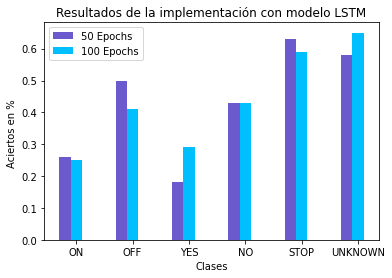

In [ ]:
barWidth=0.2
plt.bar(np.arange(len(LSTM50)), LSTM50, color="#6A5ACD", width=barWidth, label="50 Epochs");
plt.bar([x + barWidth for x in np.arange(len(LSTM50))], LSTM100, color="#00BFFF", width=barWidth, label="100 Epochs");
plt.xlabel("Clases");
plt.ylabel("Aciertos en % ");
plt.xticks([r + barWidth for r in range(len(text))], text);
plt.title("Resultados de la implementación con modelo LSTM");
plt.legend();
plt.show();

##Entrenamiento Modelo GRU

In [ ]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential(name="Modelo_GRU")
# model.add(tf.keras.layers.Embedding(4, 300, input_length=40))
model.add(tf.keras.layers.Input((92,1)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=512,
                                                          return_sequences=True,
                                                          activation='tanh',
                                                          name='GRU_layer1')))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=512,
                                                          return_sequences=True,
                                                          activation='tanh',
                                                          name='GRU_layer2')))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=256,
                                                          return_sequences=False,
                                                          activation='tanh',
                                                          name='GRU_layer3')))
model.add(tf.keras.layers.Dense(units=256, 
                                   activation='relu',
                                   name='dense1') )
model.add(tf.keras.layers.Dense(units=128, 
                                   activation='relu',
                                   name='dense2') )
model.add(tf.keras.layers.Dense(units = num_labels,
                                  activation='softmax',
                                  name='ouput_layer'))

model.summary()

Model: "Modelo_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 92, 1024)          1582080   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 92, 1024)          4724736   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               1969152   
_________________________________________________________________
dense1 (Dense)               (None, 256)               131328    
_________________________________________________________________
dense2 (Dense)               (None, 128)               32896     
_________________________________________________________________
ouput_layer (Dense)          (None, 6)                 774       
Total params: 8,440,966
Trainable params: 8,440,966
Non-trainable params: 0
______________________________________________

### 50 Epochs

Epoch 1/50
122/122 [==============================] - 9s 75ms/step - loss: 1.5968 - accuracy: 0.3887
Epoch 2/50
122/122 [==============================] - 9s 75ms/step - loss: 1.4252 - accuracy: 0.4479
Epoch 3/50
122/122 [==============================] - 9s 75ms/step - loss: 1.3523 - accuracy: 0.4774
Epoch 4/50
122/122 [==============================] - 9s 75ms/step - loss: 1.3145 - accuracy: 0.4869
Epoch 5/50
122/122 [==============================] - 9s 75ms/step - loss: 1.2944 - accuracy: 0.4990
Epoch 6/50
122/122 [==============================] - 9s 75ms/step - loss: 1.2735 - accuracy: 0.5059
Epoch 7/50
122/122 [==============================] - 9s 75ms/step - loss: 1.2438 - accuracy: 0.5190
Epoch 8/50
122/122 [==============================] - 9s 76ms/step - loss: 1.2225 - accuracy: 0.5195
Epoch 9/50
122/122 [==============================] - 9s 76ms/step - loss: 1.2027 - accuracy: 0.5269
Epoch 10/50
122/122 [==============================] - 9s 76ms/step - loss: 1.1919 - accura

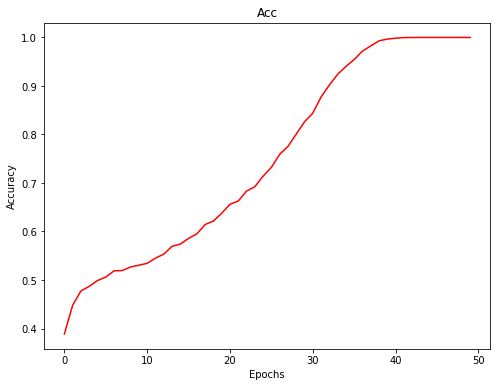

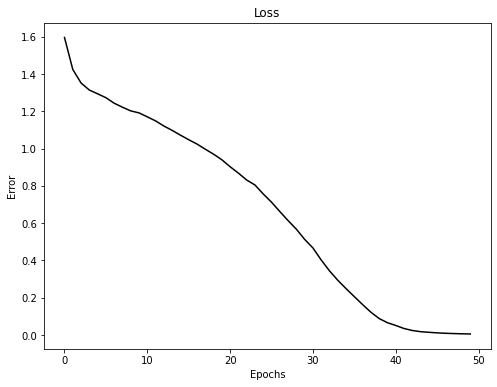

In [ ]:
#@title Entrenamiento
epochs = 50 #@param {type:"slider", min:50, max:5000, step:25}

#optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
optimizer = tf.keras.optimizers.Adam(lr=1e-4)
#optimizer = tf.keras.optimizers.Adadelta(lr=1e-2)

# optimizer = 'adam' #@param ["adam", "SGD", "adadelta"]

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=optimizer)
X = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
# print(X.shape, y_train.shape)
history = model.fit(X, y_train,epochs=epochs,verbose=1)

acc = history.history['accuracy']
loss = history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot acc and Loss
#------------------------------------------------
plt.figure(figsize=(8, 6));
plt.plot(epochs, acc, 'red', label='acc')
plt.title('Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show();
plt.figure(figsize=(8, 6));
plt.title('Loss')
plt.plot(epochs, loss, 'black', label='loss')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show();

In [ ]:
#Guardar el modelo
#@markdown optimizer_epochs_samples_features_accuracy_version

nombre = "GRU_SGD_50e_650m_2f_1_V1" #@param {type:"string"}
model.save('/content/drive/My Drive/IA2/DATA/Models/model_'+nombre+'.h5')
np.save('/content/drive/My Drive/IA2/DATA/Models/model_'+nombre+'.npy', le.classes_)

In [ ]:
# Cargar modelo
model = tf.keras.models.load_model('Models/model_GRU_SGD_50e_650m_2f_1_V1.h5')

In [ ]:
#@title Predicción
X_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)
y_predict = model.predict_classes(X_test)
y_test_single = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_test_single, y_predict)
print(conf_matrix)

[[ 64   3  13   5  52   4]
 [  3 111  23  20  29   2]
 [  9  16  82   5  55   1]
 [  6  26   6  89  28   7]
 [ 55  20  39  16 340  18]
 [  3   6   0   6  18 120]]


In [ ]:
text = ["ON", "OFF", "YES", "NO", "STOP", "UNKNOWN"]
#Vector para gráficas
GRU50=[]
for i in range(len(text)):
  acierto_promedio = conf_matrix[i][i]/(np.sum(conf_matrix[i], axis=0))
  GRU50.append(np.round(acierto_promedio, 2))
  print(f"Aciertos clase {text[i]}: {np.round(acierto_promedio*100, 2)}%")

Aciertos clase ON: 45.39%
Aciertos clase OFF: 59.04%
Aciertos clase YES: 48.81%
Aciertos clase NO: 54.94%
Aciertos clase STOP: 69.67%
Aciertos clase UNKNOWN: 78.43%


### 100 Epochs

Epoch 1/100
122/122 [==============================] - 9s 74ms/step - loss: 1.5797 - accuracy: 0.3949
Epoch 2/100
122/122 [==============================] - 9s 74ms/step - loss: 1.4171 - accuracy: 0.4541
Epoch 3/100
122/122 [==============================] - 9s 74ms/step - loss: 1.3170 - accuracy: 0.4977
Epoch 4/100
122/122 [==============================] - 9s 74ms/step - loss: 1.2791 - accuracy: 0.5026
Epoch 5/100
122/122 [==============================] - 9s 74ms/step - loss: 1.2629 - accuracy: 0.5108
Epoch 6/100
122/122 [==============================] - 9s 74ms/step - loss: 1.2443 - accuracy: 0.5172
Epoch 7/100
122/122 [==============================] - 9s 74ms/step - loss: 1.2208 - accuracy: 0.5290
Epoch 8/100
122/122 [==============================] - 9s 74ms/step - loss: 1.1951 - accuracy: 0.5403
Epoch 9/100
122/122 [==============================] - 9s 75ms/step - loss: 1.1832 - accuracy: 0.5328
Epoch 10/100
122/122 [==============================] - 9s 74ms/step - loss: 1.155

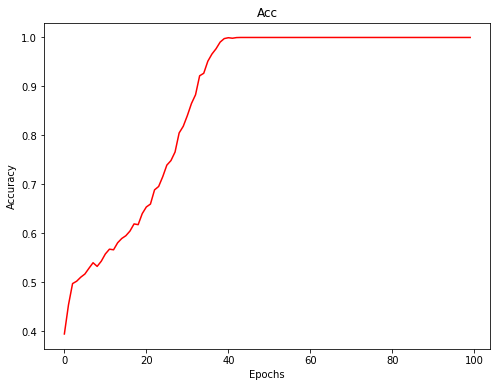

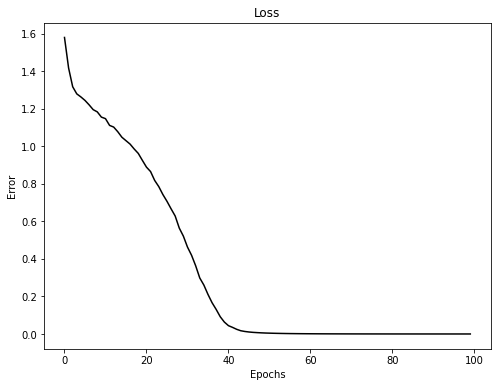

In [ ]:
#@title Entrenamiento
epochs = 100 #@param {type:"slider", min:50, max:5000, step:25}

#optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
optimizer = tf.keras.optimizers.Adam(lr=1e-4)
#optimizer = tf.keras.optimizers.Adadelta(lr=1e-2)

# optimizer = 'adam' #@param ["adam", "SGD", "adadelta"]

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=optimizer)
X = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
# print(X.shape, y_train.shape)
history = model.fit(X, y_train,epochs=epochs,verbose=1)

acc = history.history['accuracy']
loss = history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot acc and Loss
#------------------------------------------------
plt.figure(figsize=(8, 6));
plt.plot(epochs, acc, 'red', label='acc')
plt.title('Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show();
plt.figure(figsize=(8, 6));
plt.title('Loss')
plt.plot(epochs, loss, 'black', label='loss')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show();

In [ ]:
#uardar modelo
#@markdown optimizer_epochs_samples_features_accuracy_version

nombre = "GRU_SGD_100e_650m_2f_1_V1" #@param {type:"string"}
model.save('/content/drive/My Drive/IA2/DATA/Models/model_'+nombre+'.h5')
np.save('/content/drive/My Drive/IA2/DATA/Models/model_'+nombre+'.npy', le.classes_)

In [ ]:
# Cargar modelo
model = tf.keras.models.load_model('/content/drive/My Drive/IA2/DATA/Models/model_GRU_SGD_100e_650m_2f_1_V1.h5')

In [ ]:
#@title Predicción
X_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)
y_predict = model.predict_classes(X_test)
y_test_single = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_test_single, y_predict)
print(conf_matrix)

[[ 47   0  20   4  65   5]
 [  5 104  20  29  28   2]
 [ 14  27  50  16  58   3]
 [  7  23  14  78  34   6]
 [ 79  31  57  42 263  16]
 [  8   3   2   9  26 105]]


In [ ]:
text = ["ON", "OFF", "YES", "NO", "STOP", "UNKNOWN"]
#Vector para gráficas
GRU100=[]
for i in range(len(text)):
  acierto_promedio = conf_matrix[i][i]/(np.sum(conf_matrix[i], axis=0))
  GRU100.append(np.round(acierto_promedio, 2))
  print(f"Aciertos clase {text[i]}: {np.round(acierto_promedio*100, 2)}%")

Aciertos clase ON: 33.33%
Aciertos clase OFF: 55.32%
Aciertos clase YES: 29.76%
Aciertos clase NO: 48.15%
Aciertos clase STOP: 53.89%
Aciertos clase UNKNOWN: 68.63%


### Resultados con GRU

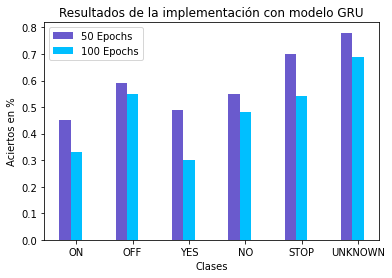

In [ ]:
barWidth=0.2
plt.bar(np.arange(len(GRU50)), GRU50, color="#6A5ACD", width=barWidth, label="50 Epochs");
plt.bar([x + barWidth for x in np.arange(len(GRU50))], GRU100, color="#00BFFF", width=barWidth, label="100 Epochs");
plt.xlabel("Clases");
plt.ylabel("Aciertos en %");
plt.xticks([r + barWidth for r in range(len(text))], text);
plt.title("Resultados de la implementación con modelo GRU");
plt.legend();
plt.show();

##Entrenamiento Modelo DNN

In [ ]:
K.clear_session()

inputs = Input(shape=(92,1))

#First Conv1D layer
conv = Conv1D(26,13, padding='valid', activation='tanh', strides=1)(inputs)
conv = MaxPooling1D(pool_size= 3)(conv)
# conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(20, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(pool_size=3)(conv)
# conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(10, 5, padding='valid', activation='relu', strides=1)(conv)
# conv = MaxPooling1D(pool_size=0)(conv)
# conv = Dropout(0.3)(conv)

# #Fourth Conv1D layer
# conv = Conv1D(5, 1, activation='relu')(conv)
# # conv = MaxPooling1D(pool_size=3)(conv)
# conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
# conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
# conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(64, activation='relu')(conv)

outputs = Dense(num_labels, activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 92, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 80, 26)            364       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 26, 26)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 20)            5740      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 20)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 10)             1010      
_________________________________________________________________
flatten (Flatten)            (None, 10)               

Epoch 1/200
122/122 [==============================] - 0s 3ms/step - loss: 1.7173 - accuracy: 0.3449
Epoch 2/200
122/122 [==============================] - 0s 3ms/step - loss: 1.6572 - accuracy: 0.3733
Epoch 3/200
122/122 [==============================] - 0s 3ms/step - loss: 1.6466 - accuracy: 0.3733
Epoch 4/200
122/122 [==============================] - 0s 3ms/step - loss: 1.6360 - accuracy: 0.3733
Epoch 5/200
122/122 [==============================] - 0s 3ms/step - loss: 1.6236 - accuracy: 0.3733
Epoch 6/200
122/122 [==============================] - 0s 3ms/step - loss: 1.6069 - accuracy: 0.3733
Epoch 7/200
122/122 [==============================] - 0s 3ms/step - loss: 1.5869 - accuracy: 0.3733
Epoch 8/200
122/122 [==============================] - 0s 3ms/step - loss: 1.5614 - accuracy: 0.3792
Epoch 9/200
122/122 [==============================] - 0s 3ms/step - loss: 1.5365 - accuracy: 0.3928
Epoch 10/200
122/122 [==============================] - 0s 3ms/step - loss: 1.5091 - accura

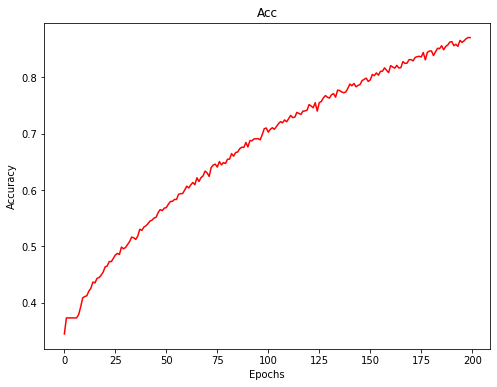

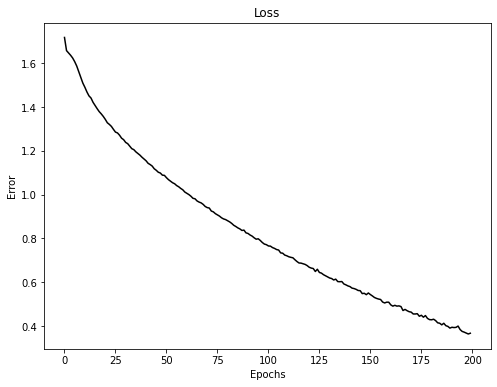

In [ ]:
#@title Entrenamiento con Adam
epochs = 200 #@param {type:"slider", min:50, max:5000, step:25}

#optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
optimizer = tf.keras.optimizers.Adam(lr=1e-4)
#optimizer = tf.keras.optimizers.Adadelta(lr=1e-2)

# optimizer = 'adam' #@param ["adam", "SGD", "adadelta"]

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=optimizer)
X = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
# print(X.shape, y_train.shape)
history = model.fit(X, y_train,epochs=epochs,verbose=1)

acc = history.history['accuracy']
loss = history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot acc and Loss
#------------------------------------------------
plt.figure(figsize=(8, 6));
plt.plot(epochs, acc, 'red', label='acc')
plt.title('Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show();
plt.figure(figsize=(8, 6));
plt.title('Loss')
plt.plot(epochs, loss, 'black', label='loss')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show();

In [ ]:
#Guardar
#@markdown optimizer_epochs_samples_features_accuracy_version

nombre = "DNN_Adamax_200e_650m_2f_0.87_V1" #@param {type:"string"}
model.save('/content/drive/My Drive/IA2/DATA/Models/model_'+nombre+'.h5')
np.save('/content/drive/My Drive/IA2/DATA/Models/model_'+nombre+'.npy', le.classes_)

In [ ]:
# Cargar modelo
model = tf.keras.models.load_model('/content/drive/My Drive/IA2/DATA/Models/model_DNN_Adamax_200e_650m_2f_0.87_V1.h5')

In [ ]:
#@title Predicción
X_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)
y_predict = np.argmax(model.predict(X_test), axis=1)
y_test_single = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_test_single, y_predict)
print(conf_matrix)

[[ 40   8   9   6  75   3]
 [  3  76  18  34  47  10]
 [ 11  15  51   8  76   7]
 [  5  19   4  86  29  19]
 [ 53  36  29  27 317  26]
 [  3   6   3  21  26  94]]


In [ ]:
text = ["ON", "OFF", "YES", "NO", "STOP", "UNKNOWN"]
#Vector para gráficas
DNN_ADAM=[]
for i in range(len(text)):
  acierto_promedio = conf_matrix[i][i]/(np.sum(conf_matrix[i], axis=0))
  DNN_ADAM.append(np.round(acierto_promedio, 2))
  print(f"Aciertos clase {text[i]}: {np.round(acierto_promedio*100, 2)}%")

Aciertos clase ON: 28.37%
Aciertos clase OFF: 40.43%
Aciertos clase YES: 30.36%
Aciertos clase NO: 53.09%
Aciertos clase STOP: 64.96%
Aciertos clase UNKNOWN: 61.44%


---

Epoch 1/200
122/122 [==============================] - 0s 3ms/step - loss: 1.9703 - accuracy: 0.3595
Epoch 2/200
122/122 [==============================] - 0s 3ms/step - loss: 1.6715 - accuracy: 0.3733
Epoch 3/200
122/122 [==============================] - 0s 3ms/step - loss: 1.6718 - accuracy: 0.3733
Epoch 4/200
122/122 [==============================] - 0s 3ms/step - loss: 1.6720 - accuracy: 0.3733
Epoch 5/200
122/122 [==============================] - 0s 3ms/step - loss: 1.6712 - accuracy: 0.3736
Epoch 6/200
122/122 [==============================] - 0s 3ms/step - loss: 1.6705 - accuracy: 0.3738
Epoch 7/200
122/122 [==============================] - 0s 3ms/step - loss: 1.6689 - accuracy: 0.3738
Epoch 8/200
122/122 [==============================] - 0s 3ms/step - loss: 1.6675 - accuracy: 0.3736
Epoch 9/200
122/122 [==============================] - 0s 3ms/step - loss: 1.6604 - accuracy: 0.3733
Epoch 10/200
122/122 [==============================] - 0s 3ms/step - loss: 1.6460 - accura

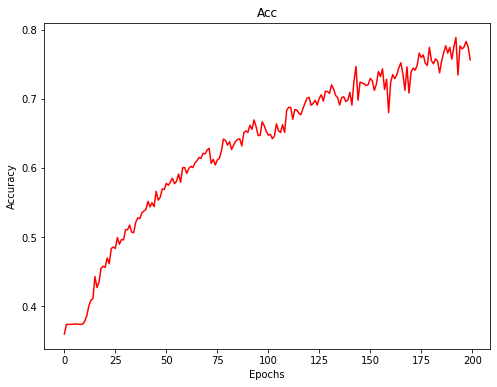

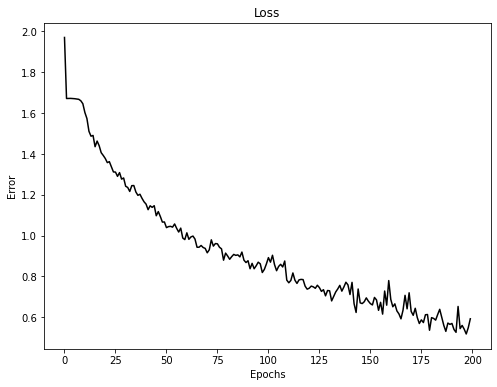

In [ ]:
#@title Entrenamiento con SGD
epochs = 200 #@param {type:"slider", min:50, max:5000, step:25}

optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
# optimizer = tf.keras.optimizers.Adam(lr=1e-4)
#optimizer = tf.keras.optimizers.Adadelta(lr=1e-2)

# optimizer = 'adam' #@param ["adam", "SGD", "adadelta"]

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=optimizer)
X = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
# print(X.shape, y_train.shape)
history = model.fit(X, y_train,epochs=epochs,verbose=1)

acc = history.history['accuracy']
loss = history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot acc and Loss
#------------------------------------------------
plt.figure(figsize=(8, 6));
plt.plot(epochs, acc, 'red', label='acc')
plt.title('Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show();
plt.figure(figsize=(8, 6));
plt.title('Loss')
plt.plot(epochs, loss, 'black', label='loss')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show();

In [ ]:
#Guardar
#@markdown optimizer_epochs_samples_features_accuracy_version

nombre = "DNN_SGD_200e_650m_2f_0.75_V1" #@param {type:"string"}
model.save('/content/drive/My Drive/IA2/DATA/Models/model_'+nombre+'.h5')
np.save('/content/drive/My Drive/IA2/DATA/Models/model_'+nombre+'.npy', le.classes_)

In [ ]:
# Cargar modelo
model = tf.keras.models.load_model('/content/drive/My Drive/IA2/DATA/Models/model_DNN_SGD_200e_650m_2f_0.75_V1.h5')

In [ ]:
#@title Predicción
X_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)
y_predict = np.argmax(model.predict(X_test), axis=1)
y_test_single = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_test_single, y_predict)
print(conf_matrix)

[[ 16  13   8  11  92   1]
 [  4  83   8  39  49   5]
 [  4  24  31   4 103   2]
 [  1  32   5  73  40  11]
 [ 13  53  22  48 335  17]
 [  4  15   0  24  36  74]]


In [ ]:
text = ["ON", "OFF", "YES", "NO", "STOP", "UNKNOWN"]
#Vector para gráficas
DNN_SGD=[]
for i in range(len(text)):
  acierto_promedio = conf_matrix[i][i]/(np.sum(conf_matrix[i], axis=0))
  DNN_SGD.append(np.round(acierto_promedio, 2))
  print(f"Aciertos clase {text[i]}: {np.round(acierto_promedio*100, 2)}%")

Aciertos clase ON: 11.35%
Aciertos clase OFF: 44.15%
Aciertos clase YES: 18.45%
Aciertos clase NO: 45.06%
Aciertos clase STOP: 68.65%
Aciertos clase UNKNOWN: 48.37%


### Resultados con DNN

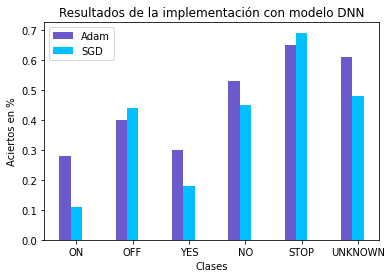

In [ ]:
barWidth=0.2
plt.bar(np.arange(len(DNN_ADAM)), DNN_ADAM, color="#6A5ACD", width=barWidth, label="Adam");
plt.bar([x + barWidth for x in np.arange(len(DNN_ADAM))], DNN_SGD, color="#00BFFF", width=barWidth, label="SGD");
plt.xlabel("Clases");
plt.ylabel("Aciertos en %");
plt.xticks([r + barWidth for r in range(len(text))], text);
plt.title("Resultados de la implementación con modelo DNN");
plt.legend();
plt.show();

#4. IMPLEMENTACIÓN
Para realizar pruebas reales con los modelos entrenados se desarrolla una interfaz compatible con el entorno del notebook. Esta implementación permite grabar una frase con el micrófono y posteriormente muestra un conteo de los comandos predichos.

In [ ]:
#@title Cargar modelo preentrenado
modelo = 'DNN_Adamax_200e_650m_2f_0.87_V1' #@param ['RNN_SGD_50e_650m_2f_0.76_V1', 'LSTM_SGD_50e_650m_2f_0.86_V1', 'GRU_SGD_50e_650m_2f_1_V1', 'DNN_Adamax_200e_650m_2f_0.87_V1']
modelo_prueba = tf.keras.models.load_model('Models/model_'+modelo+'.h5')
encoder = LabelEncoder()
encoder.classes_ = np.load('Models/model_'+modelo+'.npy')

In [ ]:
#@title .
display(IPython.display.HTML('''
<html>
  <head>
    <link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/bootstrap/4.5.0/css/bootstrap.min.css"
        integrity="sha384-9aIt2nRpC12Uk9gS9baDl411NQApFmC26EwAOH8WgZl5MYYxFfc+NcPb1dKGj7Sk" crossorigin="anonymous">
    </haed>
    <body>
      <div class="container">  
        <div class="row">
          <img src="https://drive.google.com/uc?id=1mVJfkz8r5vcVDGcmzos2f6BF5m9MiK8N" class="card-img-top" alt="banner">
        </div>   
        <div class="row">
          <div class="col-3 bg-secondary text-center text-white">
            <h4 class="text-white mt-4">RECORD COMMAND</h4>
            <audio id = "audio" style="width: 100%;" controls></audio>
            <div id="screen" style="font-family: Calibri,Arial;font-weight: 300;font-size: 45px;letter-spacing: 3px;">
              00:00
            </div>
            <button id='button' type="button" class="btn btn-primary mx-auto d-block mb-3">Record</button>
          </div>
          <div class="col-9" style="background-color: #E0E0E0; padding: 0px !important">
            <div class="container">
              <div class="row">
                <div class="p-1 w-100 text-center" style="background-color: #14B9CF;font-weight: 600;font-size: 20px;" >
                  Command: <span id="resultado">
                  <div class="spinner-border" role="status">
                    <span class="sr-only">Loading...</span>
                  </div>
                  <span>
                </div>
              </div>
              <div class="row">
                <div class="col-sm">
                  <img  width="100%" id="imagen1" src="https://drive.google.com/uc?id=1d92jKlIJL-ezrLOAtpsK2dIE6cxK7MVO" />
                </div>
                <div class="col-sm">
                  <img  width="100%" id="imagen2" src="https://drive.google.com/uc?id=19BeoY0biKIDCMej59ECN3unxrc8uwk09" />
                </div>
                <div class="col-sm">
                  <img  width="100%" id="imagen3" src="https://drive.google.com/uc?id=11-M5rIg0ifCtnL1K4tGvyRfwyaeO7VSF" />
                </div>
              </div>
              <div class="row text-center p-2" style="background-color: #c4c4c4;font-weight: 600;font-size: 16px;">
                <div class="col">
                    On <span id="on" class="badge badge-light">0</span>
                </div>
                <div class="col">
                    Off <span id="off" class="badge badge-light">0</span>
                </div>
                <div class="col">
                    Stop <span id="stop" class="badge badge-light">0</span>
                </div>
                <div class="col">
                    Yes <span id="yes" class="badge badge-light">0</span>
                </div>
                <div class="col">
                    No <span id="no" class="badge badge-light">0</span>
                </div>
                <div class="col">
                    Unknown <span id="unknown" class="badge badge-light">0</span>
                </div>
              </div>
            </div>
          </div>
        </div>
      </div>
    </body>

    <script>
      var isMarch = false; 
      var acumularTime = 0; 
      var screen = document.getElementById("screen")
      var resultado = document.getElementById("resultado")
      // var grab = document.getElementById("grabacion")
      var imagen1 = document.getElementById("imagen1")
      var imagen2 = document.getElementById("imagen2")
      var imagen3 = document.getElementById("imagen3")
      var b_on = document.getElementById("on")
      var b_off = document.getElementById("off")
      var b_stop = document.getElementById("stop")
      var b_yes = document.getElementById("yes")
      var b_no = document.getElementById("no")
      var b_unknown = document.getElementById("unknown")
      var button = document.getElementById("button")
      // var tabla = document.getElementById("tabla")
      // var load = document.getElementById("load")
      var start_rec = false;
      // tabla.style.display = "none";

      function cronometro () { 
        timeActual = new Date();
        acumularTime = timeActual - timeInicial;
        acumularTime2 = new Date();
        acumularTime2.setTime(acumularTime); 
        cc = Math.round(acumularTime2.getMilliseconds()/10);
        ss = acumularTime2.getSeconds();
        if (cc < 10) {cc = "0"+cc;}
        if (ss < 10) {ss = "0"+ss;} 
        screen.innerHTML = ss+":"+cc;
      }

      function start() {
        if (isMarch == false) { 
          timeInicial = new Date();
          control = setInterval(cronometro,10);
          isMarch = true;
        }
      }

      function stop() { 
        if (isMarch == true) {
          clearInterval(control);
          isMarch = false;
        }     
      }   
      
      function toggleRecording() {
        if (recorder && recorder.state == "recording") {
            recorder.stop();
            stop();
            gumStream.getAudioTracks()[0].stop();
        }
      }   
      async function send(base64data) {
        var c_on = 0
        var c_off = 0
        var c_yes = 0
        var c_no = 0
        var c_stop = 0
        var c_unknown = 0
        const result = await google.colab.kernel.invokeFunction('notebook.sendAudio', [base64data.toString()] , {});
        const predicts = result.data['application/json'].result
        resultado.innerHTML = predicts.toString()
        predicts.forEach(function (predict){
          console.log(predict)
          if(predict == 'on'){
            imagen1.src = "https://drive.google.com/uc?id=1H3YbVnvHhL7KiR9f_QNPgZu02Wm2b_Fd";
            c_on+=1
          }
          if(predict == 'off'){
            imagen1.src = "https://drive.google.com/uc?id=1d92jKlIJL-ezrLOAtpsK2dIE6cxK7MVO";
            c_off+=1
          }
          if(predict == 'no'){
            imagen3.src = "https://drive.google.com/uc?id=11-M5rIg0ifCtnL1K4tGvyRfwyaeO7VSF";
            c_no+=1
          }
          if(predict == 'yes'){
            imagen3.src = "https://drive.google.com/uc?id=1R7szogaVmuGFXViuqFYocfLYhO61T5X9";
            c_yes+=1
          }
          if(predict == 'stop'){
            imagen2.src = "https://drive.google.com/uc?id=19X3uT8VUZAYQXgMGs8R-ty1ifZj9IuHM";
            c_stop+=1
          }
          if(predict == 'unknow'){
            c_unknown+=1
          }
          b_no.innerHTML = c_no
          b_yes.innerHTML = c_yes
          b_on.innerHTML = c_on
          b_off.innerHTML = c_off
          b_stop.innerHTML = c_stop
          b_unknown.innerHTML = c_unknown
        })
        // 
      }

      var handleSuccess = function(stream) {
        gumStream = stream;
        var options = {
          //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
          mimeType : 'audio/webm;codecs=opus'
          //mimeType : 'audio/webm;codecs=pcm'
        };            
        recorder = new MediaRecorder(stream);
        recorder.ondataavailable = function(e) {            
          var url = URL.createObjectURL(e.data);
          var preview = document.getElementById('audio');
          preview.src = url;

          reader = new FileReader();
          reader.readAsDataURL(e.data); 
          reader.onloadend = function() {
            base64data = reader.result;
            send(base64data);
          }
        };
        recorder.start();
      };

      function grabar() {
        button.innerText = "Stop"
        imagen2.src = "https://drive.google.com/uc?id=19BeoY0biKIDCMej59ECN3unxrc8uwk09";
        button.classList.remove("btn-primary");
        button.classList.add("btn-danger");

        navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);
        start();
      }

      document.querySelector('#button').onclick = () => {
        if (start_rec){
          button.innerText = "Record"
          button.classList.remove("btn-danger");
          button.classList.add("btn-primary");
          toggleRecording()
          start_rec = false
        }else{
          // load.style.display = "none";
          // tabla.style.display = "block";
          resultado.innerHTML = '<div class="spinner-border" role="status"><span class="sr-only">Loading...</span></div>'
          // document.querySelector('#youtube-video').contentWindow.postMessage('{"event":"command","func":"' + 'playVideo' + '","args":""}', '*');
          grabar()
          b_no.innerHTML = 0
          b_yes.innerHTML = 0
          b_on.innerHTML = 0
          b_off.innerHTML = 0
          b_stop.innerHTML = 0
          b_unknown.innerHTML = 0
          start_rec = true
        }
      };
    </script>
    </html>
    '''))

def sendAudio(base64audio):

  binary = b64decode(base64audio.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))
  now = datetime.now()
  name = now.strftime('%d_%m_%Y_%H_%M_%S')
  scipy.io.wavfile.write('/content/drive/My Drive/IA2/DATA/Recs/rec_'+name+'.wav', sr, audio)
  
  name_file = '/content/drive/My Drive/IA2/DATA/Recs/rec_'+str(name)+'.wav'
  sound_file = AudioSegment.from_wav(name_file)
  audio_chunks = split_on_silence(sound_file, min_silence_len=100,silence_thresh=-25)
  result = []

  for i, chunk in enumerate(audio_chunks):
    out_file = "/content/drive/My Drive/IA2/DATA/Recs/chunk{0}.wav".format(i)
    chunk.export(out_file, format="wav")

  for i, chunk in enumerate(audio_chunks):
    # out_file = "/content/drive/My Drive/IA2/DATA/Recs/chunk{0}.wav".format(i)
    # chunk.export(out_file, format="wav")
    file_name_rec = "chunk{0}.wav".format(i)
    rec_audio = extract_features('Recs/', file_name_rec)
    chroma_audio  = extract_features_chroma('Recs/', file_name_rec)
    x_audio = np.concatenate((rec_audio, chroma_audio)).reshape(1,92,1)
    # Si es RNN, aplicar model.predict
    if "RNN" or "DNN" in modelo:
      predict_rec = modelo_prueba.predict(x_audio)
      p = encoder.inverse_transform(np.argmax(predict_rec, axis=1))[0]
    else:
      predict_rec = modelo_prueba.predict_classes(x_audio)
      p = encoder.inverse_transform(predict_rec)[0]
    
    result.append(p)

  return IPython.display.JSON({'result': result})


output.register_callback('notebook.sendAudio', sendAudio)

# 5. CONCLUSIONES

* Las características frecuenciales MFCC y Chroma, en conjunto, son una representación que garantiza una predicción aceptable de los comandos de voz. Se evidenció que el ruido influye significativamente en los resultados debido a la alta sensibilidad de los micrófonos convencionales.

* La detección de comandos en una frase es un reto de mayor complejidad en comparación a la detención de comandos por palabras, ya que el tratamiento de la frase captada depende de su duración y nivel de potencia para poder identificar cada palabra en esta.

* Una arquitectura sencilla como la DNN puede lograr un rendimiento igual o mayor de óptimo con respecto a las redes neuronales recurrentes. En las pruebas reales, el modelo con más aciertos es el DNN (Adamax). Por otro lado, para las pruebas con la partición test del dataset, el modelo GRU y RNN simple poseen una mayor precisión

# Referencias Bibliográficas:

* Bonafonte, A., (2016). El Deep Learning Revoluciona Las Tecnologías Del Habla | Blog CIT UPC. (2016). Consultado el 6 de Septiembre de 2020, en https://blog.cit.upc.edu/?p=965. 

* TensorFlow Speech Recognition Challenge | Kaggle. (2016). Consultado el 6 de Agosto de 2020, en https://www.kaggle.com/c/tensorflow-speech-recognition-challenge 

* Criptografía práctica. (2013). Consultado el 10 de agosto de 2020, en http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/
 
* Jogy, J. (2019). How I Understood: What features to consider while training audio files?. Consultado el 14 de Agosto de 2020, en https://towardsdatascience.com/how-i-understood-what-features-to-consider-while-training-audio-files-eedfb6e9002b


